## MÜZİK SİNYALLERİNİN ANALİZİ VE ANLAMLANDIRILMASI

In [1]:
import numpy, scipy, matplotlib.pyplot as plt, pandas, librosa,sklearn,IPython.display as ipd
import matplotlib.style as ms
ms.use('seaborn-muted')
%matplotlib inline

In [2]:
float_formatter = lambda x: "%.4f" % x
numpy.set_printoptions(formatter={'float_kind':float_formatter})

#### İNSAN SESİ NASIL DUYAR VE TANIMLAR ?
* Hava moleküllerinin titreşimi (Ses Dalgaları)
* Dış kulak ve ses dalgalarının yakalanması
* Orta kulak ve mekanik basınç dalgalarına aktarım
* İç kulak ve ses dalgalarının ses sinyallerine çevrilmesi
* Sinyallerin, işitme sinirleri ile beyne gönderilmesi ve yorumlanması.

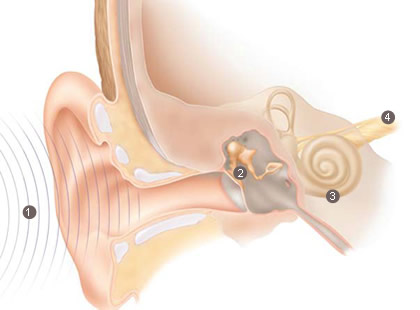

In [3]:
ipd.Image(filename='kulak.jpg')

#### SES SİNYALLERİ VE BİLGİSAYAR ORTAMINDA GÖSTERİMİ
* Ses sinyaleri, belirli bir zaman aralığında yönü ve şiddeti sürekli değişen sonsuz bir değere sahiptir. Bu analog sinyaller, belirlenen bir örnekleme oranı ile örneklenerek bilgisayarın anlayabileceği ve üzerinde işlem yapılabilecek sayısal sinyallere dönüştürülürler.

* Örneğin bir analog ses sinyali 44.1 KHz'lik bir örnekleme oranı ile örnekleniyorsa, bu analog sinyalden saniyede 44100 örnek alınacak demektir.

* **_Ek Bilgi:_** İnsan, 0-140 dB basınç aralığındaki ve 20-20000 Hz frekans aralığındaki sesleri duyabilir !

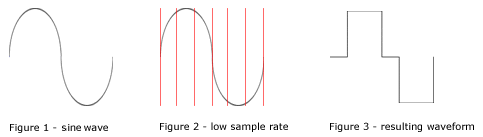

In [4]:
ipd.Image(filename='low.jpg')


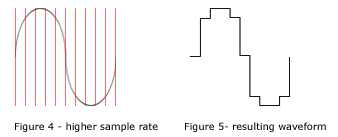

In [5]:
ipd.Image(filename='high.jpg')

* Veri setimizdeki şarkılardan, metal ve klasik müzik türü için olan iki şarkı alalım.
* Örnekleme oranımız 22.05 KHz.
* Şarkılardan 5 sn'lik parçalar alınsın.

In [12]:
sampling_rate=22050

x_metal,sr=librosa.load("./genres/metal/metal.00001.au",sr=sampling_rate,mono=True)
x_classical,sr=librosa.load("./genres/classical/classical.00001.au",sr=sampling_rate,mono=True)

In [13]:
print("Overview of the array of samples for Metal song:(size={})\n{}:\n ".format(x_metal.shape,x_metal))
print("Overview of the array of samples for Classical song:(size={})\n{}".format(x_classical.shape,x_classical))

Overview of the array of samples for Metal song:(size=(661504,))
[0.1165 0.1194 0.1234 ..., 0.0187 0.0653 0.0347]:
 
Overview of the array of samples for Classical song:(size=(661794,))
[-0.0114 -0.0022 0.0169 ..., -0.0295 -0.0378 -0.0392]


* Her iki şarkı için saniyede 22050 örnek alınarak, 5 saniye için 110250 adet örnek alınmış oldu.
* Her iki şarkı için de bu örnekler birer dizi içerisinde tutuldu.
* Dizinin her elemanı belli bir basınçtaki ses örneğini göstermektedir.

* Oluşturduğumuz dizileri, yani ses sinyal örneklerini zaman düzlemine yayarak bir grafik elde edelim.


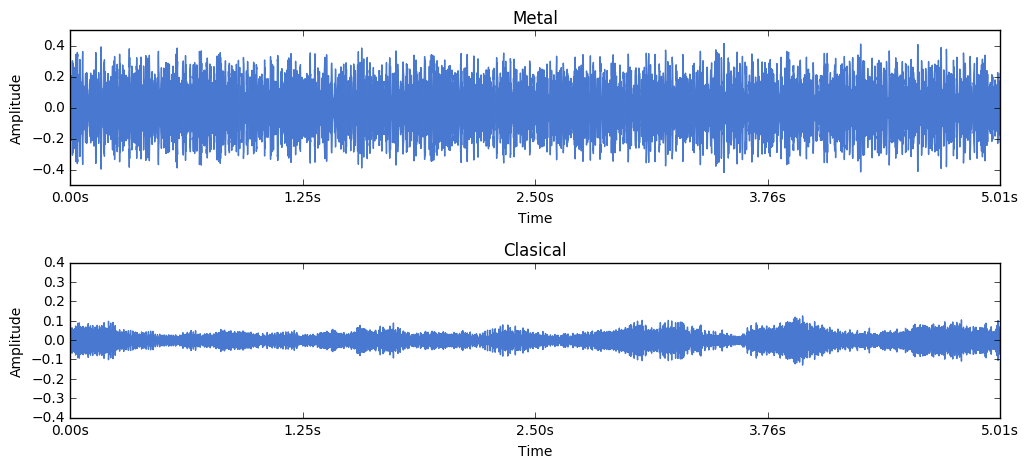

In [97]:
#Waveplot - Tİme Domain

fig=plt.figure(figsize=(12,5))
fig.subplots_adjust(hspace=.5)

plt.subplot(2, 1, 1)
plt.xlabel("Time")
plt.ylabel("Amplitude")
librosa.display.waveplot(x_metal,sampling_rate)
plt.title('Metal')

plt.subplot(2, 1, 2)
plt.ylim(-0.4,0.4)
plt.xlabel("Time")
plt.ylabel("Amplitude")
librosa.display.waveplot(x_classical,sampling_rate)
plt.title('Clasical')

* Her iki şarkı için oluşturduğumuz dizilerdeki tüm örnekleri, yine önceden kullandığımız 22.05 KHz'lik örnekleme oranı ile bir araya getirelim ve ortaya ne çıktığını görelim.

In [98]:
ipd.Audio(x_metal, rate=sampling_rate)


In [99]:
ipd.Audio(x_classical, rate=sampling_rate)

* Zaman düzleminde çizilen waveplot'lardan metal müzik türündeki şarkıda, ses sinyallerinin basınçlarının daha fazla olduğunu görebiliyoruz.
* Ancak bu şekillerde elimizde sadece sesin zamanla değişim gösteren basınç seviyesi bulunmakta.
* Bu nedenle waveplot ile ses sinyallerinin özelliklerini tam anlamıyla çözmemiz ve incelememiz mümkün değildir.

**_ÇÖZÜM ?_**
 - Fourier Tranform (Fourier Dönüşümü) (İlerleyen kısımda bahsedilecek)

* **Sesi bütün bir şekilde incelemek karmaşıktır ve elde edilen öğrenme verimi düşüktür.**
* Bu nedenle ses parçalara, bizim kullanacağımız adıyla segmentlere ayrılır.
* Her segment ayrı ayrı incelenir ve müzik hakkında daha fazla bilgiye ulaşmamıza olanak sağlar.
* Öz nitelik çıkarımı da segmentler üzerinden gerçekleşir. Her segment için ayrı ayrı hesaplanan öz nitelikler bir arada tutulur. Yapılacak işleme göre kullanılacak öz nitelikler ve segment seçimi yapılır veya tüm segmentler kullanılır (örneğin bir öz nitelik için tüm segmentlerdeki değerlerin ortalaması).

* **_Bazı Kavramlar:_**
 - Frame Length (Çerçeve Uzunluğu): Her segment (frame) için, frame'in içinde bulundurduğu örnek sayısını ifade eder. Örneğin frame length 1024 ise, her frame de 1024 adet ses sinyal örneği bulunacak şekilde ayırma işlemi yapılacak demektir.
 - Hop Length (Aralık Uzunluğu): Her frame'in kaç örnek sonrasında başlayacağını belirleyen değerdir. Örneğin hop length 512 ise baştan itibaren her 512. örnekte frame uzunluğuna göre parçalama işlemi yapılacak demektir.

* Biz kendi örneklerimiz için frame uzunluğunu 2048, aralık uzunluğunu ise 512 olarak alalım.
* Bu büyüklükler, projede kullanılan Librosa kütüphanesinde kullanılan standart örneklerdir.

In [100]:
hop_size=512
frame_size=2048

In [101]:
#Segmentation
F=librosa.util.frame(x_metal,frame_length=frame_size,hop_length=hop_size)
x,y=F.shape

print("Number of frames={} with frame size={} for Metal song".format(y,x))
print("Total number of samples= {}\n".format(y*x+hop_size))
print(F)

F2=librosa.util.frame(x_classical,frame_length=frame_size,hop_length=hop_size)
x2,y2=F2.shape

print("\nNumber of frames={} with frame size={} for Classical song".format(y2,x2))
print("Total number of samples= {}\n".format(y2*x2+hop_size))
print(F2)

Number of frames=212 with frame size=2048 for Metal song
Total number of samples= 434688

[[0.1165 -0.0085 0.0128 ..., 0.0222 -0.0954 -0.1196]
 [0.1194 -0.1501 0.0197 ..., 0.0774 -0.1232 -0.1897]
 [0.1234 -0.1673 0.0392 ..., -0.0791 -0.1354 -0.1052]
 ..., 
 [-0.1609 0.0424 0.0199 ..., 0.0194 0.0811 -0.1163]
 [-0.1255 -0.0146 -0.0022 ..., 0.0550 0.1528 -0.0857]
 [-0.1257 -0.1062 -0.0261 ..., 0.0807 0.0930 -0.0690]]

Number of frames=212 with frame size=2048 for Classical song
Total number of samples= 434688

[[-0.0114 0.0450 -0.0739 ..., 0.0551 0.0125 0.0472]
 [-0.0022 0.0277 -0.0708 ..., 0.0639 0.0123 0.0596]
 [0.0169 0.0244 -0.0596 ..., 0.0657 0.0210 0.0660]
 ..., 
 [0.0280 -0.0388 -0.0469 ..., 0.0104 -0.0251 -0.0146]
 [0.0168 -0.0306 -0.0450 ..., 0.0028 -0.0121 -0.0061]
 [0.0062 -0.0214 -0.0383 ..., -0.0015 -0.0075 -0.0044]]


* Segmentlere ayırma işlemi başka nasıl yapılabilir?
* Bir ses sinyali için karakteristik özelliklerin ortaya çıktığı her anı yakalayarak.
* Bu anlara Onset denir ve bu işlemin ismi Onset Detection olarak geçer.
* Örneğin sadece snare ve kick olan bir ses kaydı düşünelim.
* Segmentasyon yaptığımızda aradaki davul veya kick sesi olmayan kısımları da alma ihtimalimiz çok yüksektir.
* Ancak Onset Detection sayesinde sadece snare ve kick ses sinyalleri başladığı andaki kısımdan başlayarak belirlediğimiz frame uzunluğuna göre parçalama yapabiliriz.
* _Daha az frame, daha iyi sonuç !_

In [102]:
#Onset Detection
onset_frames = librosa.onset.onset_detect(x_metal, sr=sampling_rate,hop_length=hop_size)
onset_times = librosa.frames_to_time(onset_frames)
x=onset_frames.size
print("Number of detected onsets for Metal song={}".format(x))
print(onset_frames)


onset_frames2 = librosa.onset.onset_detect(x_classical, sr=sampling_rate,hop_length=hop_size)
onset_times2 = librosa.frames_to_time(onset_frames2)
x2=onset_frames2.size
print("\nNumber of detected onsets for Classical song={}".format(x2))
print(onset_frames2)

Number of detected onsets for Metal song=33
[  3   7  11  19  27  35  44  48  51  60  68  77  84  93  98 101 110 118
 127 131 135 144 151 156 163 168 175 180 184 193 196 201 205]

Number of detected onsets for Classical song=23
[  5  18  26  46  50  56  69  80  83  91 106 113 122 128 134 146 157 166
 168 180 190 200 211]


* Elde ettiğimiz onsetleri waveplot üzerinde göstererek, görsel anlamda bir inceleme yapalım.

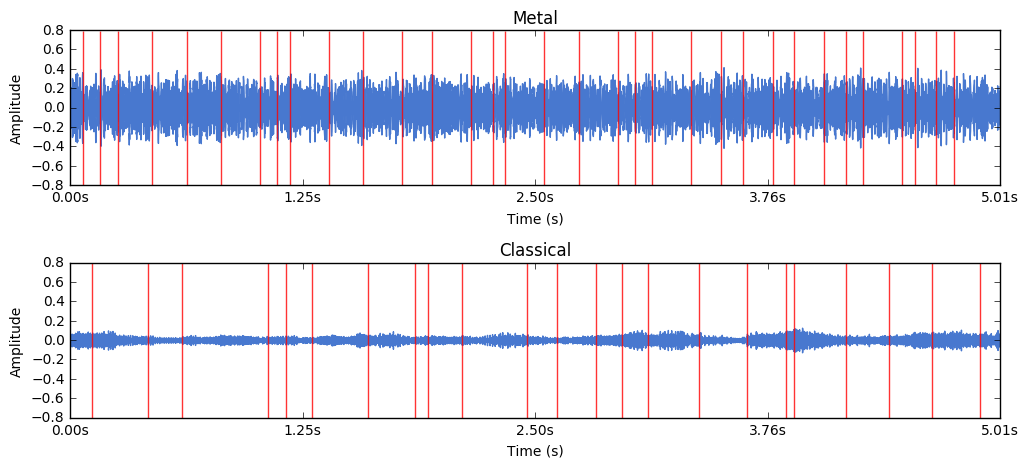

In [103]:
fig=plt.figure(figsize=(12,5))
fig.subplots_adjust(hspace=.5)

plt.subplot(2,1,1)
librosa.display.waveplot(x_metal, sr=sampling_rate)
plt.vlines(onset_times*1000, -0.8, 0.79, color='r', alpha=0.8)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title('Metal')

plt.subplot(2,1,2)
librosa.display.waveplot(x_classical, sr=sampling_rate)
plt.vlines(onset_times2*1000, -0.8, 0.79, color='r', alpha=0.8)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title('Classical')

* Elde ettiğimiz onset değerlerini her iki şarkıya da ayrı ayrı ekleyelim ve elde ettiğimiz sonucu inceleyelim.

In [104]:
clicks = librosa.clicks(frames=onset_frames, sr=sampling_rate, length=len(x_metal))
ipd.Audio(x_metal + clicks, rate=sampling_rate)

In [105]:
clicks = librosa.clicks(frames=onset_frames2, sr=sampling_rate, length=len(x_classical))
ipd.Audio(x_classical + clicks, rate=sampling_rate)

* **Fourier Transform ( Fourier Dönüşümü )**
* Elimizde bulunan zaman düzlemindeki ses sinyal gösterimini, frekans düzlemine aktarmamızı sağlar.
* Daha fazla bilgi, daha fazla yorumlama kazandırır.
* İncelediğimiz sinyali oluşturan sinüs sinyallerinin frekansları hakkında bilgi edinmemizi sağlar.
* Elde edilen grafik Spectrum olarak adlandrılır.
 


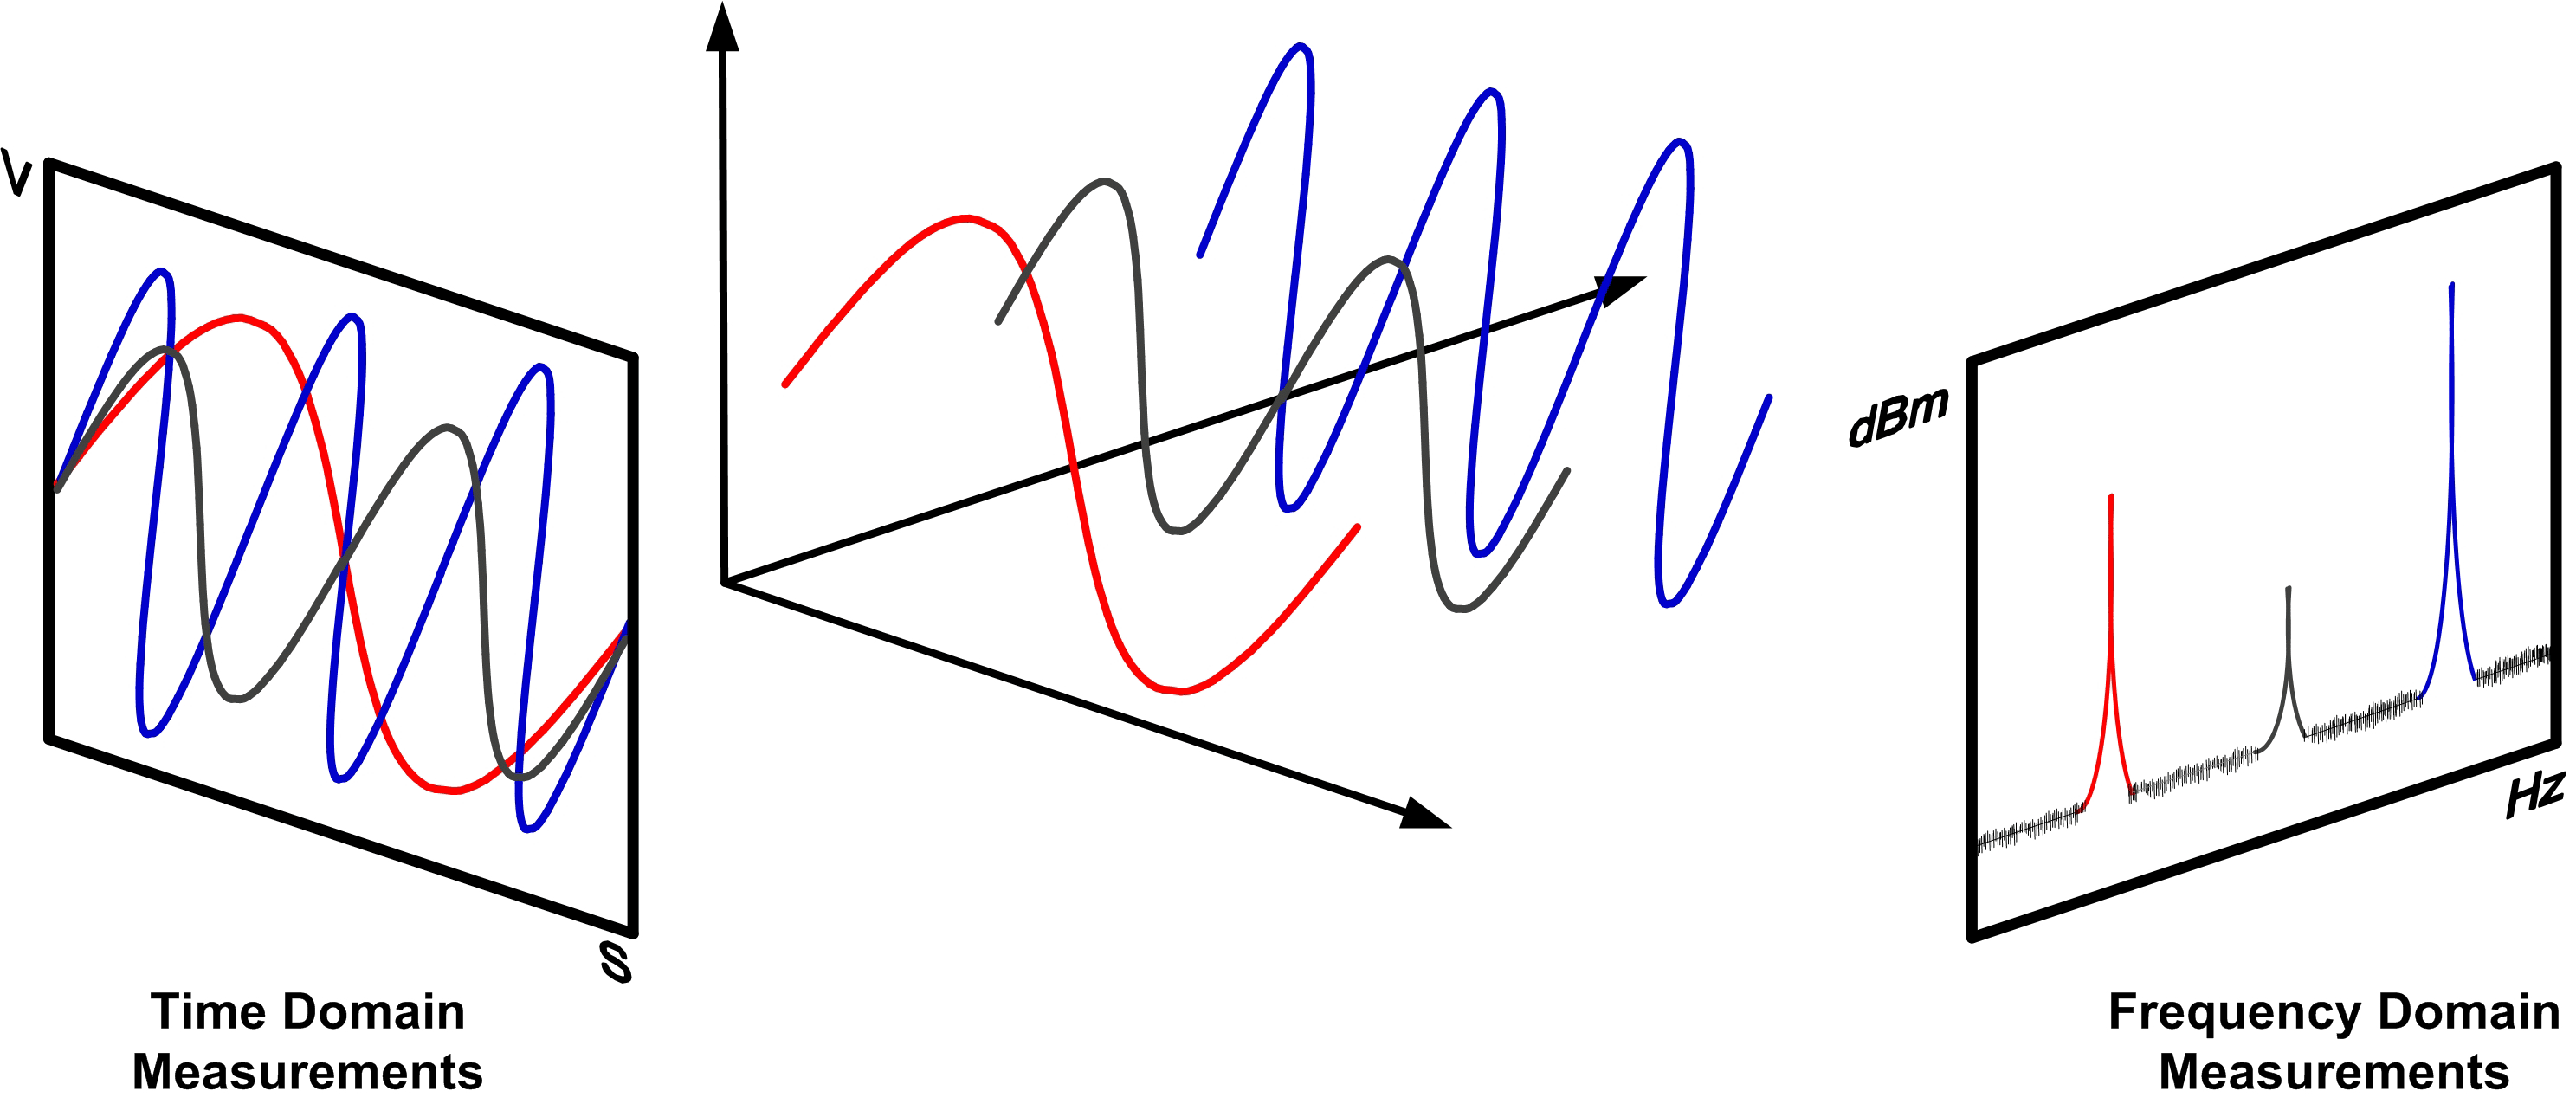

In [106]:
ipd.Image(filename='time_and_freq.jpg')

In [107]:
ipd.display(ipd.Image(url='https://upload.wikimedia.org/wikipedia/commons/7/72/Fourier_transform_time_and_frequency_domains_%28small%29.gif'))

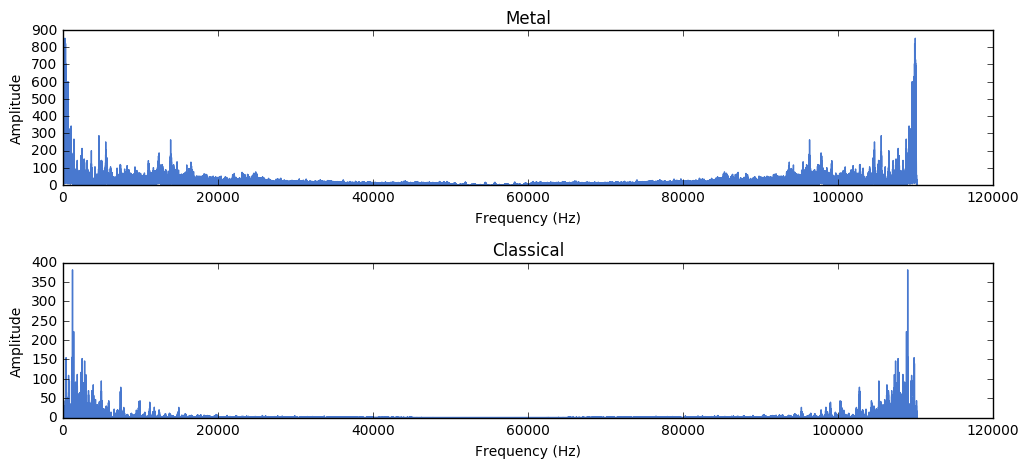

In [108]:
# Fourier Transform and Spectrum

fig=plt.figure(figsize=(12,5))
fig.subplots_adjust(hspace=.5)

plt.subplot(2,1,1)
FFT_Metal=scipy.fft(x_metal)
FFT_Metal_Mag=numpy.absolute(FFT_Metal)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.title('Metal')
plt.plot(FFT_Metal_Mag)

plt.subplot(2,1,2)
FFT_Classical=scipy.fft(x_classical)
FFT_Classical_Mag=numpy.absolute(FFT_Classical)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.title('Classical')
plt.plot(FFT_Classical_Mag)

* Fourier Dönüşümü sinyali frekans düzleminde incelememizi sağlar.
* Ancak zaman ile ilgili bir bilgi veremez.
* Hem frekans bilgisi elde edip hem de zaman ile ilgili yorumlamayı nasıl yapabiliriz?
* **Short-Time Fourier Transform**
 - Sinyali penrelere ayırır (windowing).
 - Her pencere için Fast Fourier Dönüşümü (FFT) uygular.
 - FFT uygulunan tüm pencereler bir araya getirilerek tek bir grafik olarak ortaya çıkarılır.
 - Bu grafiğe Spectogram adı verilir.
 - **_Window Size_:** FFT uygulanacak olan pencerenin örnek sayısı olarak büyüklüğü. Örneğin, bu değer 1024 ise, her pencere için 1024 adet örnek üzerinden FFT uygulanacaktır.

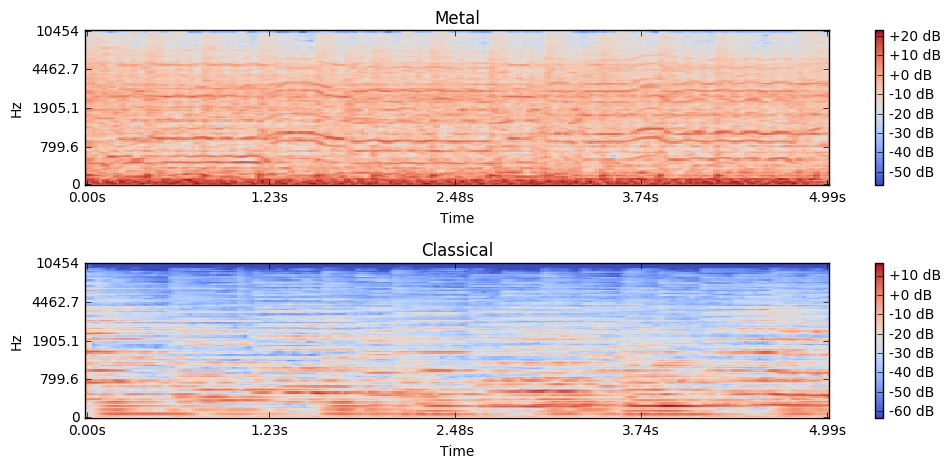

In [109]:
#Short-Time Fourier Transform and Spectogram

window_size=2048

fig=plt.figure(figsize=(12,5))
fig.subplots_adjust(hspace=.5)

plt.subplot(2,1,1)
S = librosa.feature.melspectrogram(x_metal, sr=sampling_rate, n_fft=window_size)
logS = librosa.logamplitude(S)
plt.title('Metal')
librosa.display.specshow(logS, sr=sampling_rate, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')

plt.subplot(2,1,2)
S2 = librosa.feature.melspectrogram(x_classical, sr=sampling_rate, n_fft=window_size)
logS2 = librosa.logamplitude(S2)
plt.title('Classical')
librosa.display.specshow(logS2, sr=sampling_rate, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')

* Daha önceden elde ettiğimiz onset değerlerini bir de Spectogram üstünde gösterelim.

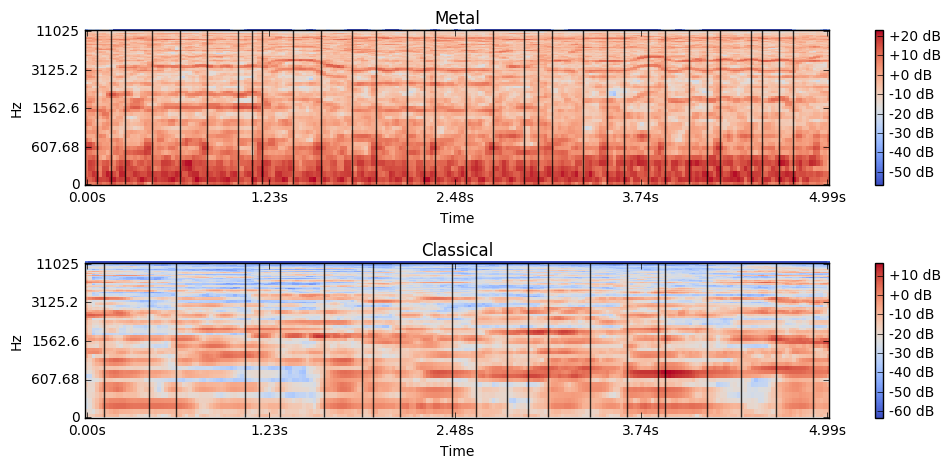

In [110]:
fig=plt.figure(figsize=(12,5))
fig.subplots_adjust(hspace=.5)

plt.subplot(2,1,1)
S = librosa.feature.melspectrogram(x_metal, sr=sampling_rate, n_fft=window_size)
logS = librosa.logamplitude(S)
plt.title('Metal')
librosa.display.specshow(logS, sr=sampling_rate, x_axis='time', y_axis='log')
plt.vlines(onset_frames, 0, logS.shape[0], color='k', alpha=0.8)
plt.colorbar(format='%+2.0f dB')

plt.subplot(2,1,2)
S2 = librosa.feature.melspectrogram(x_classical, sr=sampling_rate, n_fft=window_size)
logS2 = librosa.logamplitude(S2)
plt.title('Classical')
librosa.display.specshow(logS2, sr=sampling_rate, x_axis='time', y_axis='log')
plt.vlines(onset_frames2, 0, logS.shape[0], color='k', alpha=0.8)
plt.colorbar(format='%+2.0f dB')

* **Constant-Q Transform**
 - Eğer Spectrogram'daki zaman düzleminde gösterdiğimiz değerleri frekans olarak değil de, ses perdesi (Pitch) olarak almak istiyorsak Constant-Q Transform uygulanır.
 - Sesin hangi ses perdeleri üzerinden ilerlediğini görmemizi sağlar.
 - Ortaya çıkan grafiğe Chromagram adı verilir.

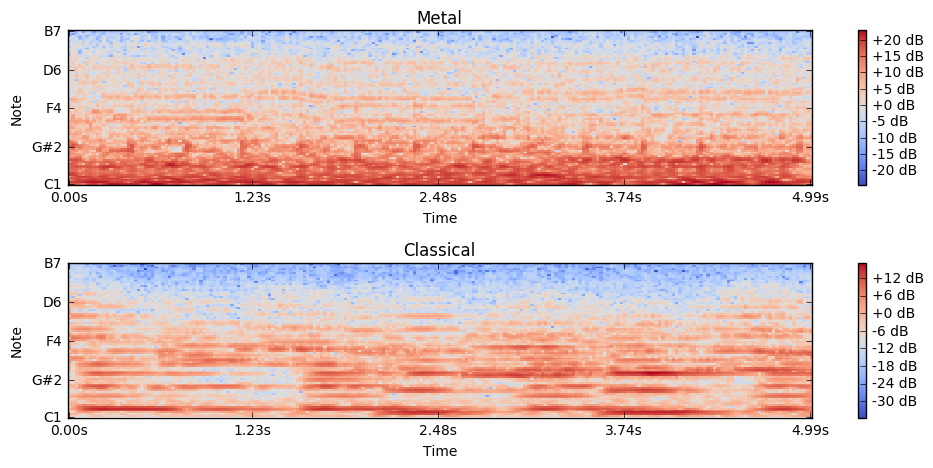

In [111]:
#Canstant-Q Transform and Chromagram

fig=plt.figure(figsize=(12,5))
fig.subplots_adjust(hspace=.5)

plt.subplot(2,1,1)
C = librosa.cqt(x_metal, sr=sampling_rate,hop_length=hop_size,real=False,fmin=librosa.note_to_hz('C2'))
logC = librosa.logamplitude(C)
plt.title('Metal')
librosa.display.specshow(logC, sr=sampling_rate, x_axis='time', y_axis='cqt_note',cmap='coolwarm',)
plt.colorbar(format='%+2.0f dB')

plt.subplot(2,1,2)
C2 = librosa.cqt(x_classical, sr=sampling_rate,hop_length=hop_size,real=False,fmin=librosa.note_to_hz('C2'))
logC2 = librosa.logamplitude(C2)
plt.title('Classical')
librosa.display.specshow(logC2, sr=sampling_rate, x_axis='time', y_axis='cqt_note',cmap='coolwarm')
plt.colorbar(format='%+2.0f dB')

* Ses değerlerini spesifik olarak ses perdeleri için değil de, ses perde sınıfları için inceleyelim.

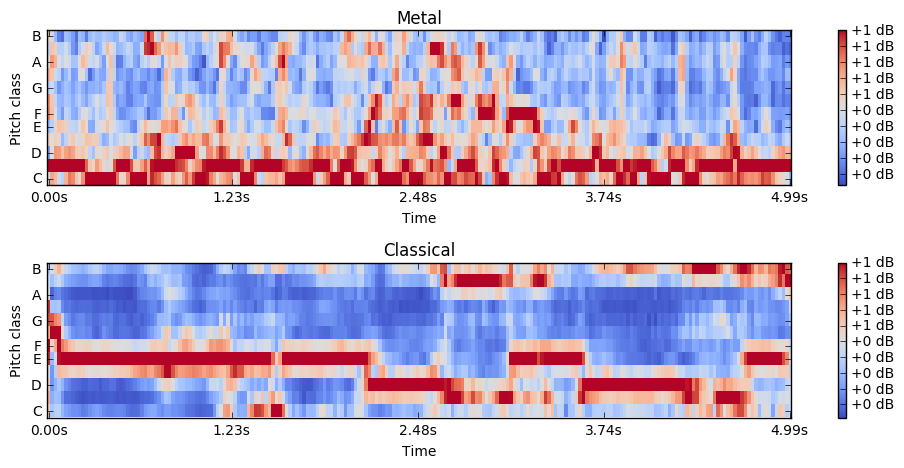

In [112]:
#Canstant-Q Transform and Chromagram with Pitch Classes

fig=plt.figure(figsize=(12,5))
fig.subplots_adjust(hspace=.5)

plt.subplot(2,1,1)
C = librosa.feature.chroma_cqt(x_metal, sr=sampling_rate,hop_length=hop_size,fmin=librosa.note_to_hz('C2'))
plt.title('Metal')
librosa.display.specshow(C, sr=sampling_rate, x_axis='time', y_axis='chroma',cmap='coolwarm')
plt.colorbar(format='%+2.0f dB')

plt.subplot(2,1,2)
C2 = librosa.feature.chroma_cqt(x_classical, sr=sampling_rate,fmin=librosa.note_to_hz('C2'))
plt.title('Classical')
librosa.display.specshow(C2, sr=sampling_rate, x_axis='time', y_axis='chroma',cmap='coolwarm')
plt.colorbar(format='%+2.0f dB')